In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

In [2]:
if "classification" in os.path.abspath(os.path.curdir): os.chdir("..")
BASE_DIR = os.path.abspath(os.path.curdir)
DATASET_DIR = os.path.join(BASE_DIR, "datasets", "classification", "flowers")

## Data Preprocessing
    - Images come from different sources and shapes.
    - so first need to make them into same size

In [5]:
from PIL import Image, ImageOps
image_path = os.path.join(BASE_DIR, "datasets", "classification", "flowers", "daisy", "5547758_eea9edfd54_n.jpg")
rgb_image = Image.open(image_path)
rgb_image = np.array(rgb_image)

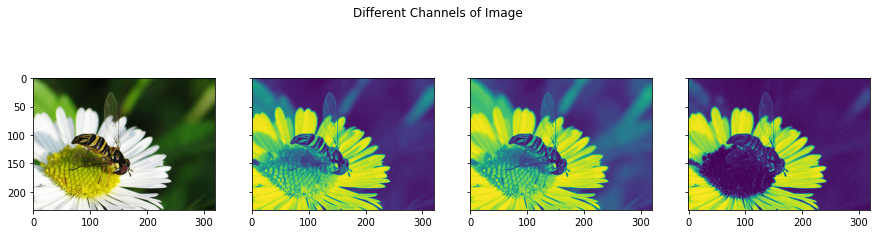

In [6]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(rgb_image)

# RGB channels
# CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
ax2.imshow(rgb_image[:, : , 0]) #Red
ax3.imshow(rgb_image[:, : , 1]) #Green
ax4.imshow(rgb_image[:, : , 2]) #Blue
f.suptitle('Different Channels of Image')
plt.show()

# ref: https://towardsdatascience.com/data-preprocessing-and-network-building-in-cnn-15624ef3a28b

### Morphological Transformation
    - The term morphological transformation refers to any modification involving the shape and form of the images.
    -Although they are used with all types of images, they are especially powerful for images that are not natural (come from a source other than a picture of the real world). 
    - The typical transformations are erosion, dilation, opening, and closing. 
    
    ref: https://towardsdatascience.com/data-preprocessing-and-network-building-in-cnn-15624ef3a28b

#### Thresholding
    - One of the simpler operations where we take all the pixels whose intensities are above a certain threshold and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a binary image.

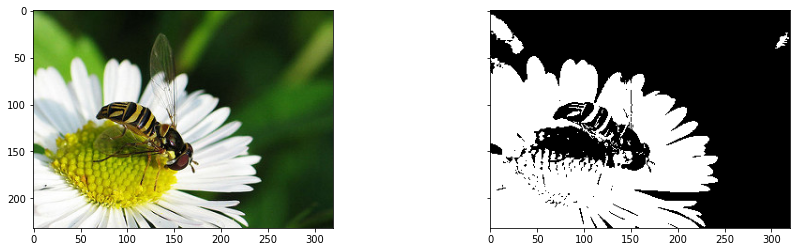

In [7]:
# 125 is Arbitrary heuristic measure halfway between 1 and 255 (the range of image pixel)
bin_image = rgb_image[:, :, 0] > 125
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(15)
ax1.imshow(rgb_image)
ax2.imshow(bin_image, cmap="gray")
plt.show()

#### Erosion, Dilation, Opening and Closing
    - Erosion shrinks bright regions and enlarges dark regions. Dilation on the other hand is exact opposite side — it shrinks dark regions and enlarges the bright regions.
    - Opening is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.
    - Closing is dilation followed by erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

In [9]:
from skimage.morphology import binary_closing, binary_dilation, \
                                binary_erosion, binary_opening
from skimage.morphology import selem

C:\Users\hp\AppData\Local\Temp/ipykernel_13184/534275832.py:3: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology import selem


In [10]:
selem = selem.disk(3)

In [11]:
open_image = binary_opening(bin_image, selem)
close_image = binary_closing(bin_image, selem)

eroded_image = binary_erosion(bin_image, selem)
dilated_image = binary_dilation(bin_image, selem)

In [12]:
import math

def plot_image(image_list, cmap="gray", column=3, width=15, height=None, *args):
    row = math.ceil(len(image_list)/column)
    height = row * 4 if not height else height
    plt.figure(figsize=(width, height))
    
    for i, image in enumerate(image_list):
        plt.subplot(row, column, i+1)
        plt.imshow(image, cmap=cmap)
    plt.show()

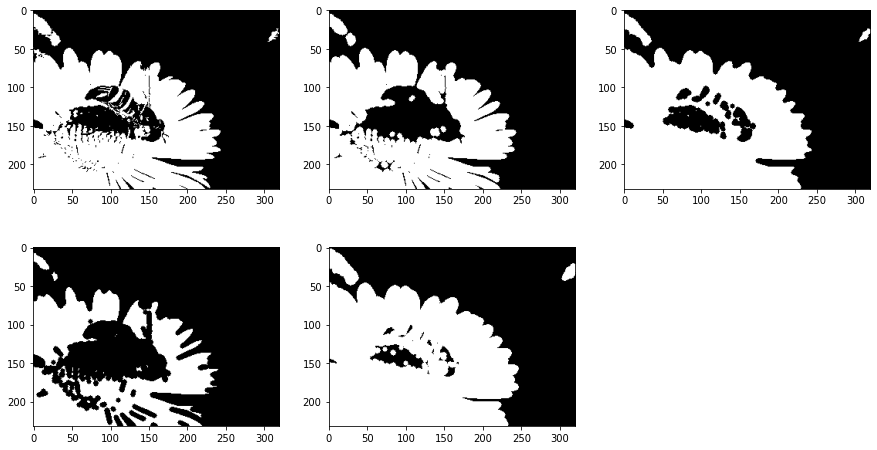

In [13]:
plot_image([bin_image, open_image, close_image, eroded_image, dilated_image])

### Normalisation
    -  This refers to rescaling the pixel values so that they lie within a confined range. One of the reasons to do this is to help with the issue of propagating gradients

In [14]:
#way1-this is common technique followed in case of RGB images 
norm1_image = rgb_image/255
#way2-in case of medical Images/non natural images 
norm2_image = rgb_image - np.min(rgb_image)/np.max(rgb_image) - np.min(rgb_image)
#way3-in case of medical Images/non natural images 
norm3_image = rgb_image - np.percentile(rgb_image,5)/ np.percentile(rgb_image,95) - np.percentile(rgb_image,5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


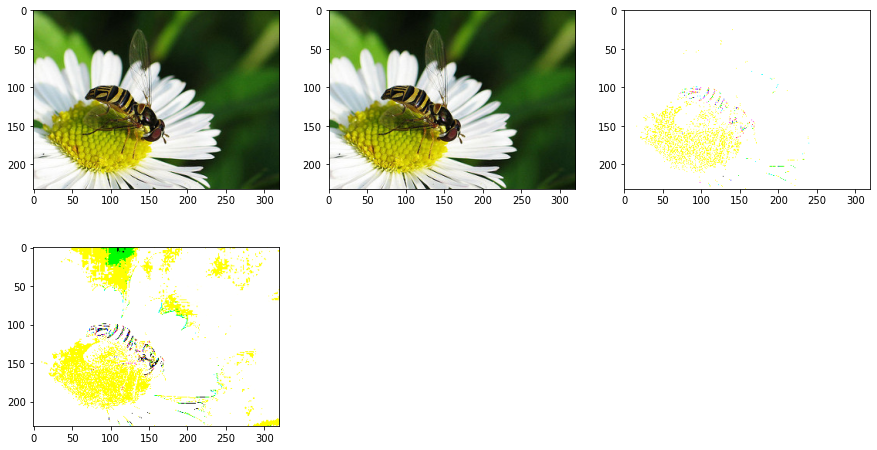

In [15]:
plot_image([rgb_image, norm1_image, norm2_image, norm3_image], cmap="gray")

### Augmentation
    - Many times, the quantity of data that we have is not sufficient to perform the task of classification well enough. In such cases, we perform data augmentation
    - As an example, if we are working with a dataset of classifying gemstones into their different types, we may not have enough number of images (since high-quality images are difficult to obtain). In this case, we can perform augmentation to increase the size of your dataset
    - As you know that pooling increases the invariance. If a picture of a dog is in the top left corner of an image, with pooling, you would be able to recognize if the dog is in little bit left/right/up/down around the top left corner. But with training data consisting of data augmentation like flipping, rotation, cropping, translation, illumination, scaling, adding noise, etc., the model learns all these variations. This significantly boosts the accuracy of the model. So, even if the dog is there at any corner of the image, the model will be able to recognize it with high accuracy.
    - There are multiple types of augmentations possible. The basic ones transform the original image using one of the following types of transformations:
        1. Linear Transformations
        2. Affine Transformations

##### Note:
    - augmentation is only be done on training set not on validation set
    - augmntation is one of the more detail concepts so will be implemented where and when needed. more details can be found with below reference
    ref - https://towardsdatascience.com/data-preprocessing-and-network-building-in-cnn-15624ef3a28b
 
    

## Data Preparations

In [3]:
from skimage import io
from skimage.color import rgb2gray

class LoadData:
    def __init__(self, dim=(100, 100), n_channel=3):
        self.dim = dim
        self.n_channel = n_channel
        self.dir_list = [dir_ for dir_ in os.listdir(DATASET_DIR) if "csv" not in dir_]
        self.path_list = []
        self.category_map = {}
        for i, dir_ in enumerate(self.dir_list):
            dir_path = os.path.join(DATASET_DIR, dir_)
            path_list = [os.path.join(dir_path, image_file) \
                         for image_file in os.listdir(dir_path)]
            self.path_list += path_list
            self.category_map.update({i: {"category": dir_, "count": len(path_list)}})
        self.ignored_index = []
        
        
    def image_to_rgb_array(self):
        if not self.path_list: self.get_image_path()
        X = np.empty((len(self.path_list), *self.dim, self.n_channel))
        y = np.empty(len(self.path_list), dtype=int)
        
        count = 0
        brp = []
        for k, v in self.category_map.items():
            count += v["count"]
            brp.append(count)
            
        j = 0
        category = 0
        for i, path in enumerate(self.path_list):
            if i >= brp[category]: category += 1
            image = io.imread(path)
            image = image/255 # normalizaion
            h, w, d = image.shape
            if h > 100 and w > 100:
                image = image[int(h/2)-50:int(h/2)+50,
                             int(w/2)-50:int(w/2)+50,
                             :]
                X[j,] = image
                y[j,] = category
                j = j + 1
            else:
                X = np.delete(X, -1, axis=0)
                y = np.delete(y, -1, axis=0)
                self.ignored_index.append(i)
        return X, y
                    
            
    def rgb_to_gray(self, X):
        X_gray = np.empty((X.shape[0], *self.dim))
        for i in range(X.shape[0]):
            X_gray[i, ] = rgb2gray(X[i])
        return X_gray
        
        
    def to_dataframe(self, X, y=None):
        df =  pd.DataFrame(X[0].flatten().reshape(1, -1))
        for i in range(1, X.shape[0]):
            array = X[i]
            df = df.append(pd.DataFrame(array.flatten().reshape(1, -1)))
        df.reset_index(drop=True, inplace=True)
        if not isinstance(y, np.ndarray):
            return df
        return pd.concat([df, pd.DataFrame(y.reshape(-1, 1))], axis=1)
            
    def to_csv(self, df, filename):
        df.to_csv(os.path.join(DATASET_DIR, filename))
        
    def df_to_array(self, df):
        return df.to_numpy()
    
    def get_original_image(self, index):
        count = 0
        for value in self.ignored_index:
            if index >= value: 
                count += 1
        return io.imread(self.path_list[index+count])
    
        def stratified_shuffle_split(self, X, y, n_splits=1, random_state=42, test_size=0.2):
            split = StratifiedShuffleSplit(n_splits=n_splits, random_state=random_state, test_size=test_size)
            for train_index, test_index in split.split(X, y):
                X_train = X[train_index]
                y_train = y[train_index]
                X_test = X[test_index]
                y_test = y[test_index]

            return X_train, X_test, y_train, y_test

In [4]:
ld = LoadData()
ld.category_map

{0: {'category': 'daisy', 'count': 764},
 1: {'category': 'dandelion', 'count': 1052},
 2: {'category': 'rose', 'count': 784},
 3: {'category': 'sunflower', 'count': 733},
 4: {'category': 'tulip', 'count': 984}}

In [261]:
# X, y = ld.image_to_rgb_array()

In [274]:
# # See sample
# i_ = 2009
# print(f"category: {y[i_]}")
# plt.imshow(X[i_])
# plt.show()

#### TrainTest Split with Shuffle and Save - RGB

In [50]:
# df = ld.to_dataframe(X, y)
# ld.to_csv(df, "all_images_with_labels_in_rgb.csv")

In [284]:
# X_train, X_test, y_train, y_test = ld.stratified_shuffle_split(X, y)

# # to check shape of data
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

# # just to varify the praportion of true values after split in train and test
# print(f"TRAIN: {np.sum(y_train==True)/len(y_train)}")
# print(f"TEST: {np.sum(y_test==True)/len(y_test)}")

In [264]:
# df = ld.to_dataframe(X_train, y_train)
# ld.to_csv(df, "train_images_with_labels_with_shuffle_split_in_rgb.csv")
# df = ld.to_dataframe(X_test, y_test)
# ld.to_csv(df, "test_images_with_labels_with_shuffle_split_in_rgb.csv")

In [54]:
# X_gray = ld.rgb_to_gray(X)
# df = ld.to_dataframe(X_gray, y)
# ld.to_csv(df, "all_images_with_labels_in_gray.csv")

#### TrainTest Split with Shuffle and Save - GRAY

In [267]:
# X_gray = ld.rgb_to_gray(X)

In [268]:
# df = ld.to_dataframe(X_gray, y)
# ld.to_csv(df, "all_images_with_labels_in_gray.csv")

In [285]:
# X_train, X_train, y_train, y_test = ld.stratified_shuffle_split(X_gray, y)

# # to check shape of data
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

# # just to varify the praportion of true values after split in train and test
# print(f"TRAIN: {np.sum(y_train==True)/len(y_train)}")
# print(f"TEST: {np.sum(y_test==True)/len(y_test)}")

In [270]:
# df = ld.to_dataframe(X_train, y_train)
# ld.to_csv(df, "train_images_with_labels_with_shuffle_split_in_gray.csv")
# df = ld.to_dataframe(X_test, y_test)
# ld.to_csv(df, "test_images_with_labels_with_shuffle_split_in_gray.csv")

### Data Loading

In [5]:
df = pd.read_csv(os.path.join(DATASET_DIR, "train_images_with_labels_with_shuffle_split_in_gray.csv"))
df.drop(df.columns[0], axis=1, inplace=True)
df.shape

(3451, 10001)

In [6]:
X_train = ld.df_to_array(df.iloc[:, :-1])
y_train = ld.df_to_array(df.iloc[:, -1:])

#### Binary Classifier

In [7]:
y_binary = y_train == 2 # 2 is category for rose
y_binary = y_binary.ravel()

## Model Training

### SGD Classfiier

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

In [9]:
sgd_clf.fit(X_train, y_binary)

SGDClassifier(random_state=42)

#### Sample Accuracy Test

In [10]:
arg = np.argmax(y_binary==True)
X_sample = X_train[arg]
y_binary[arg]

True

In [11]:
sgd_clf.predict([X_sample])

array([ True])

In [12]:
y_predictions = sgd_clf.predict(X_train)
accuracy = sum(y_predictions == y_binary)/len(y_binary)
print(accuracy)

0.9466821211243118


In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_binary, cv=3, scoring="accuracy")

array([0.66203301, 0.81130435, 0.57304348])

In [14]:
y_score = sgd_clf.decision_function([X_sample])
y_score

array([54.26441747])

In [15]:
threshold = 0
y_score > threshold

array([ True])

#### Accuracy Measure

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, \
                            precision_score, recall_score, f1_score, \
                            precision_recall_curve, \
                            roc_curve, \
                            roc_auc_score

y_predictions = cross_val_predict(sgd_clf, X_train, y_binary, cv=3)
confusion_matrix(y_binary, y_predictions)

array([[2223,  602],
       [ 495,  131]], dtype=int64)

##### Observations
    - Obviously unacceptable outcome

#### PR Curve

In [17]:
precision_score(y_binary, y_predictions)

0.17871759890859482

In [18]:
recall_score(y_binary, y_predictions)

0.20926517571884984

In [19]:
f1_score(y_binary, y_predictions)

0.19278881530537156

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_binary, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_binary, y_scores)

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(("Precision", "Recall"))
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.grid()
    plt.show()

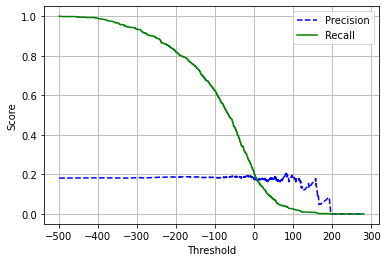

In [22]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("Recalls")
    plt.ylabel("Precisions")
    plt.grid()
    plt.show()

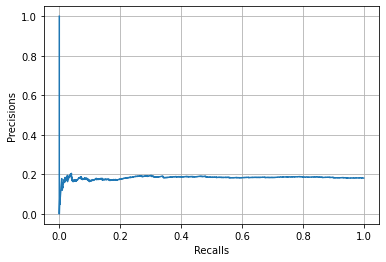

In [24]:
plot_precision_vs_recall(precisions, recalls)

In [25]:
def get_requied_precision(pr_rate):
    threshold = thresholds[np.argmax(precisions>=pr_rate)]
    return y_scores >= threshold
y_req_precision = get_requied_precision(0.15)

In [26]:
precision_score(y_binary, y_req_precision)

0.18144927536231883

In [27]:
recall_score(y_binary, y_req_precision)

1.0

#### ROC curve

In [28]:
fpr, tpr, thresholds = roc_curve(y_binary, y_scores)

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(label)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Negative Rate")
    plt.grid()
    plt.show()

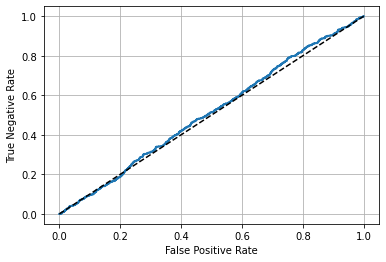

In [30]:
plot_roc_curve(fpr, tpr)

In [31]:
roc_auc_score(y_binary, y_predictions)

0.49808391529305324